# Oriented Bounding Boxes through Faster R-CNN

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
import os
import glob
import cv2
import imageio.v2 as imageio

## Dataset Visualization

In [2]:
dataset_folder = "./dataset/files/"
img_dir = os.path.join(dataset_folder, "img")
annots_dir = os.path.join(dataset_folder, "annots")

In [3]:
images_path = glob.glob(os.path.join(img_dir, "*.jpg"))
annotations_path = [os.path.join(annots_dir, os.path.basename(img) + ".json") for img in images_path]

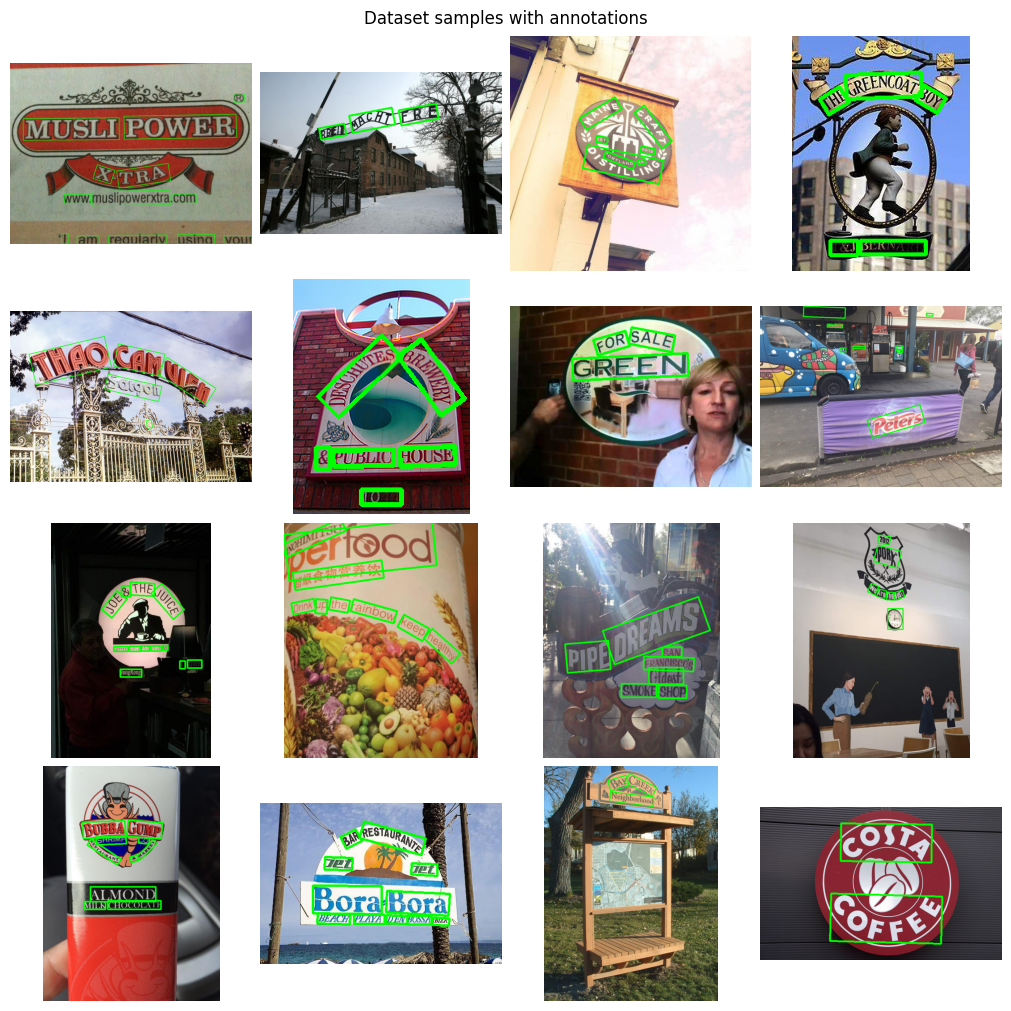

In [4]:
fig, axs = plt.subplots(4, 4, figsize=(10, 10), constrained_layout=True)
for i, (img_path, annot_path) in enumerate(zip(images_path, annotations_path)):
    if i == 16:
        break
    img = plt.imread(img_path)
    img_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    with open(annot_path, "r") as f:
        annot = json.load(f)
        xc = [detec["obb"]["xc"] for detec in annot["objects"]]
        yc = [detec["obb"]["yc"] for detec in annot["objects"]]
        w = [detec["obb"]["w"] for detec in annot["objects"]]
        h = [detec["obb"]["h"] for detec in annot["objects"]]
        theta = [detec["obb"]["theta"] for detec in annot["objects"]]
        
        for x, y, width, height, angle in zip(xc, yc, w, h, theta):
            rect = cv2.boxPoints(((x, y), (width, height), angle))
            rect = np.intp(rect)
            cv2.drawContours(img_bgr, [rect], 0, (0, 255, 0), 4)
    
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    axs[i//4, i%4].imshow(img_rgb)
    axs[i//4, i%4].axis("off")

plt.suptitle("Dataset samples with annotations")
plt.show()


## Understanding Faster RCNN

### Hyperparameters

- `rpn_post_nms_top_n_train`
- `rpn_fg_iou_thresh`
-  `rpn_positive_fraction`
  
Hyperparam 1: (2000, 0.8, 0.8) \
Hyperparam 2 : (1000, 0.7, 0.5) \
Hyperparam 3: (500, 0.5, 0.3) 


In [5]:
def load_arrays(filename):
    """Loads multiple appended NumPy arrays from a file."""
    arrays = []
    with open(filename, "rb") as f:
        while True:
            try:
                arrays.append(np.load(f, allow_pickle=False))
            except EOFError:
                break 
    return arrays

In [6]:
epochs = 20
num_features = 5
num_images = 4
images_path = 'outputs/images/'

### Original Images

| ![](results/images/image_0.jpg) | ![](results/images/image_1.jpg) |
|--|--|
| ![](results/images/image_2.jpg) | ![](results/images/image_3.jpg) |


### Objectness Score

In [7]:
for hyperparam_idx in range(1,4):
    output_folder = f"outputs/{hyperparam_idx}/objectness"
    os.makedirs(f"{output_folder}/images", exist_ok=True)
    os.makedirs(f"{output_folder}/gifs", exist_ok=True)
    
    # read all the files
    features = []
    for i in range(num_features):
        features.append(load_arrays(f"{output_folder}/feature_{i}.npy"))
    for img_idx in range(num_images):
        for epoch in range(epochs):
            # make plots and save them
            fig, axs = plt.subplots(1, 5, figsize=(15, 3), constrained_layout=True)
            for i in range(5):
                img = features[i][num_images*epoch + img_idx]
                img = (img - img.min()) / (img.max() - img.min())
                axs[i].imshow(img)
                axs[i].axis("off")
                axs[i].set_title(f"Feature {i}")
            plt.suptitle(f"Hyperparams {hyperparam_idx} - Image {img_idx+1} - Epoch {epoch+1}")
            plt.savefig(f"{output_folder}/images/epoch_{epoch}_img_{img_idx}.png")
            plt.close()
            
        # make gifs
        with imageio.get_writer(f"{output_folder}/gifs/img_{img_idx}.gif", mode='I') as writer:
            for epoch in range(epochs):
                writer.append_data(imageio.imread(f"{output_folder}/images/epoch_{epoch}_img_{img_idx}.png"))
    
    # delete the images
    for img_idx in range(4):
        for epoch in range(epochs):
            os.remove(f"{output_folder}/images/epoch_{epoch}_img_{img_idx}.png")
    os.rmdir(f"{output_folder}/images")
    

| ![](results/1/objectness/gifs/img_0.gif) | ![](results/1/objectness/gifs/img_1.gif) |
|--|--|
| ![](results/1/objectness/gifs/img_2.gif) | ![](results/1/objectness/gifs/img_3.gif) |


| ![](results/2/objectness/gifs/img_0.gif) | ![](results/2/objectness/gifs/img_1.gif) |
|--|--|
| ![](results/2/objectness/gifs/img_2.gif) | ![](results/2/objectness/gifs/img_3.gif) |


| ![](results/3/objectness/gifs/img_0.gif) | ![](results/3/objectness/gifs/img_1.gif) |
|--|--|
| ![](results/3/objectness/gifs/img_2.gif) | ![](results/3/objectness/gifs/img_3.gif) |

### Object Proposals

In [10]:
for hyperparam_idx in range(1,4):
    output_folder = f"outputs/{hyperparam_idx}/object_proposals"
    output_file = f"{output_folder}/boxes.npy"
    os.makedirs(f"{output_folder}/images", exist_ok=True)
    os.makedirs(f"{output_folder}/gifs", exist_ok=True)
    
    list_boxes = load_arrays(output_file)

    for img_idx in range(num_images):
        for epoch in range(epochs):
            # make plots and save them
            fig, axs = plt.subplots(1,1, figsize=(8, 8), constrained_layout=True)
            img = plt.imread(images_path+"image_"+str(img_idx)+".jpg")
            width, height = img.shape[1], img.shape[0]
            img_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
            for box in list_boxes[epoch*num_images+img_idx][::5]:
                box[0], box[1], box[2], box[3] = box[0] * width, box[1] * height, box[2] * width, box[3] * height
                box = [int(x) for x in box]
                rect = cv2.rectangle(img_bgr, (box[0], box[1]), (box[2], box[3]), (0, 255, 0), 2)
            img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
            axs.imshow(img_rgb)
            axs.axis("off")
            plt.suptitle(f"Hyperparams {hyperparam_idx} - Image {img_idx+1} - Epoch {epoch+1}")
            plt.savefig(f"{output_folder}/images/epoch_{epoch}_img_{img_idx}.png")
            plt.close()
            
        # make gifs
        with imageio.get_writer(f"{output_folder}/gifs/img_{img_idx}.gif", mode='I') as writer:
            for epoch in range(epochs):
                writer.append_data(imageio.imread(f"{output_folder}/images/epoch_{epoch}_img_{img_idx}.png"))
                
    # delete the images
    for img_idx in range(4):
        for epoch in range(epochs):
            os.remove(f"{output_folder}/images/epoch_{epoch}_img_{img_idx}.png")
    os.rmdir(f"{output_folder}/images")


| ![](results/1/object_proposals/gifs/img_0.gif) | ![](results/1/object_proposals/gifs/img_1.gif) |
|--|--|
| ![](results/1/object_proposals/gifs/img_2.gif) | ![](results/1/object_proposals/gifs/img_3.gif) |

| ![](results/2/object_proposals/gifs/img_0.gif) | ![](results/2/object_proposals/gifs/img_1.gif) |
|--|--|
| ![](results/2/object_proposals/gifs/img_2.gif) | ![](results/2/object_proposals/gifs/img_3.gif) |

| ![](results/3/object_proposals/gifs/img_0.gif) | ![](results/3/object_proposals/gifs/img_1.gif) |
|--|--|
| ![](results/3/object_proposals/gifs/img_2.gif) | ![](results/3/object_proposals/gifs/img_3.gif) |

### Bounding Box Assignments

In [9]:
for hyperparam_idx in range(1,4):
    output_folder = f"outputs/{hyperparam_idx}/bb_assignments"
    background_file = f"{output_folder}/background_boxes.npy"
    foreground_file = f"{output_folder}/foreground_boxes.npy"
    ignore_file = f"{output_folder}/ignore_boxes.npy"
    os.makedirs(f"{output_folder}/images", exist_ok=True)
    
    background_boxes = load_arrays(background_file)
    foreground_boxes = load_arrays(foreground_file)
    ignore_boxes = load_arrays(ignore_file)
    
    # print(len(background_boxes), len(foreground_boxes), len(ignore_boxes))
    # print(foreground_boxes)
    # break
    
    for img_idx in range(num_images):
        bg_box = background_boxes[img_idx]
        fg_box = foreground_boxes[img_idx]
        ig_box = ignore_boxes[img_idx]
        # print(bg_box)
        # break
        
        # take boxes at equal intervals but total boxes should be 10
        bg_box = bg_box[::len(bg_box)//10]
        if len(fg_box) > 10:
            fg_box = fg_box[::len(fg_box)//10]
        ig_box = ig_box[::len(ig_box)//10]
        
        # make plots and save them
        fig, axs = plt.subplots(1,3, figsize=(15, 5), constrained_layout=True)
        img = plt.imread(images_path+"image_"+str(img_idx)+".jpg")
        width, height = img.shape[1], img.shape[0]
        img_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        img_bgr_bg = img_bgr.copy()
        img_bgr_fg = img_bgr.copy()
        img_bgr_ig = img_bgr.copy()
        
        for box in bg_box:
            box[0], box[1], box[2], box[3] = box[0] * width, box[1] * height, box[2] * width, box[3] * height
            box = [int(x) for x in box]
            rect = cv2.rectangle(img_bgr_bg, (box[0], box[1]), (box[2], box[3]), (0, 0, 255), 2)
        img_rgb_bg = cv2.cvtColor(img_bgr_bg, cv2.COLOR_BGR2RGB)
        axs[0].imshow(img_rgb_bg)
        axs[0].axis("off")
        axs[0].set_title("Background")
        
        for box in fg_box:
            box[0], box[1], box[2], box[3] = box[0] * width, box[1] * height, box[2] * width, box[3] * height
            box = [int(x) for x in box]
            rect = cv2.rectangle(img_bgr_fg, (box[0], box[1]), (box[2], box[3]), (0, 255, 0), 2)
        img_rgb_fg = cv2.cvtColor(img_bgr_fg, cv2.COLOR_BGR2RGB)
        axs[1].imshow(img_rgb_fg)
        axs[1].axis("off")
        axs[1].set_title("Foreground")
        
        for box in ig_box:
            box[0], box[1], box[2], box[3] = box[0] * width, box[1] * height, box[2] * width, box[3] * height
            box = [int(x) for x in box]
            rect = cv2.rectangle(img_bgr_ig, (box[0], box[1]), (box[2], box[3]), (255, 0, 0), 2)
        img_rgb_ig = cv2.cvtColor(img_bgr_ig, cv2.COLOR_BGR2RGB)
        axs[2].imshow(img_rgb_ig)
        axs[2].axis("off")
        axs[2].set_title("Ignore")
        plt.suptitle(f"Hyperparams {hyperparam_idx} - Image {img_idx+1}")
        plt.savefig(f"{output_folder}/images/img_{img_idx}.png")
        plt.close()

| ![](results/1/bb_assignments/images/img_0.png) | ![](results/1/bb_assignments/images/img_1.png) |
|--|--|
| ![](results/1/bb_assignments/images/img_2.png) | ![](results/1/bb_assignments/images/img_3.png) |

| ![](results/2/bb_assignments/images/img_0.png) | ![](results/2/bb_assignments/images/img_1.png) |
|--|--|
| ![](results/2/bb_assignments/images/img_2.png) | ![](results/2/bb_assignments/images/img_3.png) |

| ![](results/3/bb_assignments/images/img_0.png) | ![](results/3/bb_assignments/images/img_1.png) |
|--|--|
| ![](results/3/bb_assignments/images/img_2.png) | ![](results/3/bb_assignments/images/img_3.png) |

### ROI Head Output

In [14]:
for hyperparam_idx in range(1,4):
    output_folder = f"outputs/{hyperparam_idx}/roi_head_outputs"
    predictions_file = f"{output_folder}/predictions.npy"
    proposals_file = f"{output_folder}/proposals.npy"
    scores_file = f"{output_folder}/scores.npy"
    os.makedirs(f"{output_folder}/images", exist_ok=True)
    os.makedirs(f"{output_folder}/gifs", exist_ok=True)
    
    predictions = load_arrays(predictions_file)
    proposals = load_arrays(proposals_file)
    scores = load_arrays(scores_file)
    
    num_boxes = len(proposals[0])
    
    for img_idx in range(num_images):
        for epoch in range(epochs):
            # make plots and save them
            fig, axs = plt.subplots(1, 1, figsize=(8, 8), constrained_layout=True)
            img = plt.imread(images_path+"image_"+str(img_idx)+".jpg")
            width, height = img.shape[1], img.shape[0]
            img_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

            # show proposal and prediction with score on top of each prediction
            for i in range(0,10):
            # for i in range(0,num_boxes):
                box = proposals[epoch*num_images+img_idx][i]
                box[0], box[1], box[2], box[3] = box[0] * width, box[1] * height, box[2] * width, box[3] * height
                box = [int(x) for x in box]
                rect = cv2.rectangle(img_bgr, (box[0], box[1]), (box[2], box[3]), (255, 0, 0), 2)
                
                cv2.rectangle(img_bgr, (box[0], box[1]-20), (box[0]+40, box[1]), (0, 0, 0), -1)
                cv2.putText(img_bgr, f"{scores[epoch*num_images+img_idx][i][0]:.2f}", (box[0], box[1]-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
                
                box_preds = predictions[epoch*num_images+img_idx][i]
                box_preds[0], box_preds[1], box_preds[2], box_preds[3] = box_preds[0] * width, box_preds[1] * height, box_preds[2] * width, box_preds[3] * height
                box_preds = [int(x) for x in box_preds]
                # box_preds = [int(box[i] + box_preds[i]) for i in range(4)]
                rect = cv2.rectangle(img_bgr, (box_preds[0], box_preds[1]), (box_preds[2], box_preds[3]), (0, 255, 0), 1)
                
            img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
            axs.imshow(img_rgb)
            axs.axis("off")
            plt.suptitle(f"Hyperparams {hyperparam_idx} - Image {img_idx+1} - Epoch {epoch+1}")
            plt.savefig(f"{output_folder}/images/epoch_{epoch}_img_{img_idx}.png")
            plt.close()
            
        # make gifs
        with imageio.get_writer(f"{output_folder}/gifs/img_{img_idx}.gif", mode='I') as writer:
            for epoch in range(epochs):
                writer.append_data(imageio.imread(f"{output_folder}/images/epoch_{epoch}_img_{img_idx}.png"))
                
    # delete the images
    for img_idx in range(4):
        for epoch in range(epochs):
            os.remove(f"{output_folder}/images/epoch_{epoch}_img_{img_idx}.png")
    os.rmdir(f"{output_folder}/images")


| ![](results/1/roi_head_outputs/gifs/img_0.gif) | ![](results/1/roi_head_outputs/gifs/img_1.gif) |
|--|--|
| ![](results/1/roi_head_outputs/gifs/img_2.gif) | ![](results/1/roi_head_outputs/gifs/img_3.gif) |

| ![](results/2/roi_head_outputs/gifs/img_0.gif) | ![](results/2/roi_head_outputs/gifs/img_1.gif) |
|--|--|
| ![](results/2/roi_head_outputs/gifs/img_2.gif) | ![](results/2/roi_head_outputs/gifs/img_3.gif) |

| ![](results/3/roi_head_outputs/gifs/img_0.gif) | ![](results/3/roi_head_outputs/gifs/img_1.gif) |
|--|--|
| ![](results/3/roi_head_outputs/gifs/img_2.gif) | ![](results/3/roi_head_outputs/gifs/img_3.gif) |

## Sample Run Results
- AP for class background = nan 
- AP for class text = 0.5160
- Mean Average Precision : 0.5160